# Breast Cancer Tumor Classification Analysis:
## _Applying Random Forests and Advanced Cross Validation_
---

Prepared By: Jason Schenck  
Date: February 27th 2017  
CSC-570 Data Science Essentials


<br>
<big>Table Of Contents</big>

---
* [1 Introduction][Introduction]  


* [2 Data Preparation][Data Preparation]


* [3 Grid Search][Grid Search]


* [4 Random Forest Model][Random Forest Model]


* [5 Cross Validation][Cross Validation]

---

[Introduction]: #1.-Introduction
[Data Preparation]: #2.-Data-Preparation
[Grid Search]: #3.-Grid-Search
[Random Forest Model]: #4.-Random-Forest-Model
[Cross Validation]: #5.-Cross-Validation

In [41]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn import cross_validation
import math

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 1. Introduction 

This analysis will be using a dataset consisting of tumor observations and classification of malignancy provided by my professor Mike Bernico. I will be building a prediction model by implementing a Random Forest Classifier and using an exhaustive gridsearch to tune for hyper parameters.

The model accuracy will be scored on the metric of AUC (Area Under Curve). I will discuss the accuracy, precision, recall, and AUC for the model. Lastly, I will use the K-Fold Cross Validation to find an average score for the model with a 95% confidence interval.

The methods used below are extremely powerful and useful in the field of data science, and can be applied to almost any type of data to generate accurate and efficient models of prediction in little time. 

### 2. Data Preparation

In [42]:
# Store the data 
data = pd.read_csv("breast_cancer.csv")

In [43]:
data.head()

,Unnamed: 0,id number,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,malignant
0,0,1000025,5,1,1,1,2,1,3,1,1,0
1,1,1002945,5,4,4,5,7,10,3,2,1,0
2,2,1015425,3,1,1,1,2,2,3,1,1,0
3,3,1016277,6,8,8,1,3,4,3,7,1,0
4,4,1017023,4,1,1,3,2,1,3,1,1,0


In [44]:
# I won't be using the following columns: 'Unamed 0' and 'id number'. These columns are not useful for prediction.
# Drop above columns from data frame.
data = data.drop(['Unnamed: 0', 'id number'], axis=1)

# Slice off the y column and store for prediction. I want to predict y = malignant (0 - no, 1 - yes).
y = data.pop("malignant")

# Split the data into training and testing sets using a 20% holdout (80/20)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=.2, random_state=42)

### 3. Grid Search

Now instead of simply instantiating a typical RandomForestClassifier() model, I will use an exhaustive **grid search** to find **hyper-parameters** for the model first.

The following definitions are from [scikit-learn](http://scikit-learn.org/stable/modules/grid_search.html#grid-search)
>"**Hyper-Parameters** are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes."
>
>"**Grid Search** is provided by GridSearchCV() and it exhaustively (brute force) generates candidates from a grid of parameter values specified prior to running."
>



In [45]:
### Grid Search
n_estimators = [300,400,500,1000,2000]
max_features = ['auto', 'sqrt','log2', 0.9, 0.2]
min_samples_split = [2,3,5,7,9]
min_samples_leaf = [1,2,3,4]


rfc = RandomForestClassifier(n_jobs=1)
#Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(rfc,
                         dict(n_estimators=n_estimators,
                              max_features=max_features,
                              min_samples_split=min_samples_split,
                              min_samples_leaf=min_samples_leaf
                              ), cv=None, n_jobs=-1)

In [46]:
estimator.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [300, 400, 500, 1000, 2000], 'max_features': ['auto', 'sqrt', 'log2', 0.9, 0.2], 'min_samples_split': [2, 3, 5, 7, 9], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

### 4. Random Forest Model

#### Set Model as Best Estimator

In [47]:
# Display the best RF model found by grid search
estimator.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.2, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [48]:
# Set the RF model to the best model returned by our grid search.
best_rfc = estimator.best_estimator_

#### Accuracy

Accuracy is defined as the ratio of correct predictions to total predictions on the testing set by our model.

$$Accuracy = \frac{Correct \, Predictions}{Total \, Number \, of \, Predictions}$$

In [49]:
accuracy = accuracy_score(y_test, best_rfc.predict(X_test))
print ("Accuracy: ", accuracy)

Accuracy:  0.971428571429


#### Precision & Recall

Precision and Recall give us a means of estimating the potential for Type I and Type II errors for our model. They are defined as follows:

<br>
$$ Precision = \frac{True \, Positives}{True \, Positives + False \, Positives} $$
<br>
<br>
$$ Recall = \frac{True \, Positives}{True \, Positives + False \, Negatives} $$

In [50]:
print (classification_report(y_test, best_rfc.predict(X_test)))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98        95
          1       0.96      0.96      0.96        45

avg / total       0.97      0.97      0.97       140



Interpreting the above results for precision and recall, in regard to precision we can see that this model will accurately predict 96% of malignant tumors, however that means that it will incorrectly predict a tumore as malignant 4% of the time. 

We find that 98% of the time the model will classify a _non-malignant_ tumor correctly, while _2% of the time will incorrectly classify a cancerous tumor as non-malignant_.

While 98% is pretty good for a model, this figure is entirely subjective to the field that the model is being used for. For example 98% preciction precision and recall may be fantastic when it comes to a model that predicts winners of a game of bowling. However, if this model were used to classify 100,000 patient tumors as malignant or not, then this means that our model will miss 2,000 (2% * 100,000 tumor predictions) cancerous tumors. That could potentially be devastating depending on the use of this model in practice. 

In [51]:
print (confusion_matrix(y_test, best_rfc.predict(X_test)))

[[93  2]
 [ 2 43]]


#### Interpretation of Confusion Matrix
The confusion matrix shows us that there is a total number of 43 _true positives_ (bottom right corner).
The number of total _false positives_ is 2 (top right corner).

>**Precision:**  43 / 43 + 2 = .96

The number of _false negatives_ is 2 (bottom left corner)

>**Recall:**   43 / 43 + 2 = .96

#### AUC

In [52]:
roc = roc_auc_score(y_test, best_rfc.predict_proba(X_test)[:,1])
print ("AUC Score: ", roc)

AUC Score:  0.997660818713


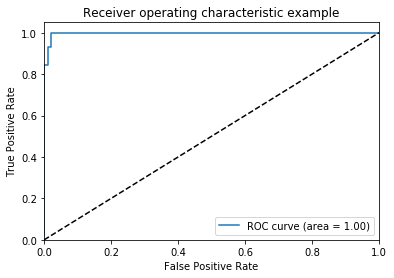

In [53]:
fpr, tpr, thresholds = roc_curve(y_test, best_rfc.predict_proba(X_test)[:,1])
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### 5. Cross Validation 

#### K-Fold Technique

In [54]:
scores = cross_validation.cross_val_score(best_rfc, data, y, cv=10)

In [55]:
scores

array([ 0.92957746,  0.98571429,  0.97142857,  0.91428571,  0.98571429,
        0.97142857,  0.98571429,  0.98571429,  0.98550725,  0.98550725])

In [56]:
mean_score = scores.mean()
std_dev = scores.std()
std_error = scores.std() / math.sqrt(scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print("95% Confident that model will fall between:")
print ("Score %f +/-  %f" % (mean_score, ci))

95% Confident that model will fall between:
Score 0.970059 +/-  0.017827
